In [1]:
# the library used
import numpy as np
import pandas as pd
import pysubgroup as ps
import re
from sklearn.feature_extraction import DictVectorizer
import time
import ast
import string 
import imblearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from plotly import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
import functions
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

### data prepare

In [42]:
# read the data
data = pd.read_csv("/Users/sunwen/Desktop/dataset/all_data.csv")
# data = pd.read_csv("/Users/xujingjing/Desktop/chefkoch_2/dataset/all_data.csv")

In [45]:
# extract the recipe id from recipe urls
list_cat_no = []
i = 0
for item in data['recipe_url']:
    list_cat_no.append(item.split('/')[4])
    
# add one column "recipe_id" into the dataset and set it as the index of dataset
data['recipe_id'] = list_cat_no
data = data.set_index(["recipe_id"])

In [39]:
# extract the numerical value string in the column calorie 
pat = r"([-+]?\d*\.\d+|\d+)"
data["calorie_value"] = data["calorie"].str.extract(pat, flags=0, expand=True)
data["preparation_time_value"] = data["preparation_time"].str.extract(pat, flags=0, expand=True)
# drop all rows with nan value in both columns comment_user and calorie_value
data_com = data.dropna(subset=["comment_user",'calorie_value'])
len(data_com)

19058

In [63]:
# expand the corresponding recipe data for each comment user
df_com_1 = functions.extract_com_user(data_com)
df_com_2 = functions.sub_cat_in_com(data_com)
df_com_3 = functions.add_recipe_info(data_com)
df_com_new = df_com_1.merge(df_com_2, on='recipe_id', how='left')
df_com_new = df_com_new.merge(df_com_3, on='recipe_id', how='left')

#df_com_new = df_com_new[['recipe_id','recipe_name','tags','difficulty','preparation_time','ingredient','name','rating','sex','age','marriage_status','comment_time','calorie_value']]
df_com_new = df_com_new.set_index(["recipe_id"])

### Empty & Imbalance Issues

- refers to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

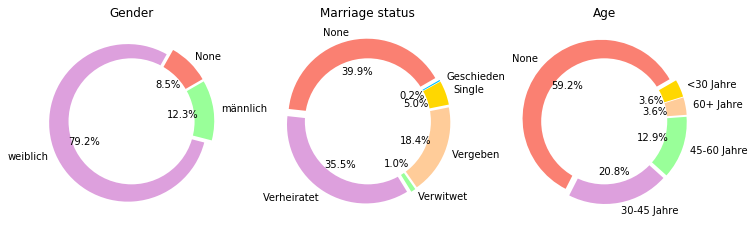

In [11]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
# box plot for gender
ax = axes[0]
values = [0.08480497, 0.7918148 , 0.12338023]
labels = ['None', 'weiblich', 'männlich']
colors = ['salmon','plum','#99ff99','#ffcc99',"gold","deepskyblue"]
explode = (0.05,0.05,0.05,0.05,0.05)
ax.pie(values, colors = colors, labels=labels, autopct='%1.1f%%',startangle=30,explode=[0.05]*len(values))
ax.set_title("Gender")
#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
ax.add_artist(centre_circle)

# box plot for marriage status
ax = axes[1]
values_2 = [0.39941795, 0.35499501, 0.0096205,0.18399406, 0.04958289,  0.00238958]
labels_2 = ['None', 'Verheiratet', 'Verwitwet','Vergeben', 'Single','Geschieden']
colors = ['salmon','plum','#99ff99','#ffcc99',"gold","deepskyblue"]
explode = (0.05,0.05,0.05,0.05,0.05)
ax.pie(values_2, colors = colors, labels=labels_2, autopct='%1.1f%%',startangle=30,explode=[0.05]*len(labels_2))
ax.set_title("Marriage status")
#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
ax.add_artist(centre_circle)

# box plot for marriage status
ax = axes[2]
values_3 = [0.59176726, 0.20807714, 0.12857412, 0.0358261 , 0.03575538]
labels_3 = ['None', '30-45 Jahre', '45-60 Jahre', '60+ Jahre', '<30 Jahre']
colors = ['salmon','plum','#99ff99','#ffcc99',"gold","deepskyblue"]
explode = (0.05,0.05,0.05,0.05,0.05)
ax.pie(values_3, colors = colors, labels=labels_3, autopct='%1.1f%%',startangle=30,explode=[0.05]*len(labels_3))
ax.set_title("Age")
#draw circle
centre_circle = plt.Circle((0,0),0.80,fc='white')
ax.add_artist(centre_circle)


### Analysis from None

In [154]:
# the ratio of female give marriage_status 
tf = df_com_new[df_com_new['sex']=='weiblich']
tf['marriage_status'].value_counts()['None']/len(tf)

0.41634647941232755

In [155]:
len(tf)

203787

In [156]:
tf['marriage_status'].value_counts()['None']

84846

In [34]:
tf['age'].value_counts()['None']/len(tf)

0.4610500179108579

In [37]:
# the ratio of male give marriage_status 
tf = df_com_new[df_com_new['sex']=='männlich']
tf['marriage_status'].value_counts()['None']/len(tf)

0.4416451470680859

In [38]:
tf['age'].value_counts()['None']/len(tf)

0.37929079800969956

Interesting rule: More female tends to give marriage_status than man, and in the contrary less female tends to give their age information than man

### Correlation between attributes

- refers to https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [64]:
# remove none value in the whole data set 
df_com_no_none = df_com_new.mask(df_com_new.astype(object).eq('None')).dropna()
df_com_no_none = df_com_no_none.reset_index()

In [66]:
df_com_no_none["preparation_time"] = df_com_no_none["preparation_time"].str.extract(pat, flags=0, expand=True)
df_com_no_none["age"] = df_com_no_none["age"].str.extract(pat, flags=0, expand=True)
df_com_no_none["rating"] = df_com_no_none["rating"].str.extract(pat, flags=0, expand=True)
dict_marriage = {'Verheiratet':1, 'Vergeben':2, 'Single':3, 'Verwitwet':4, 'Geschieden':5}
dict_sex = {'männlich':1, 'weiblich':2}
dict_difficulty = {'simpel':1, 'normal':2, 'pfiffig':3}
#df_com_no_none['marriage'] = df_com_no_none['marriage_status'].map(dict_marriage)
#df_com_no_none['sex'] = df_com_no_none['sex'].map(dict_sex)
#df_com_no_none['difficulty'] = df_com_no_none['difficulty'].map(dict_difficulty)

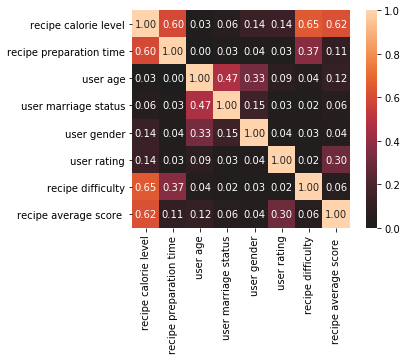

{'corr':                          recipe calorie level  recipe preparation time  \
 recipe calorie level                 1.000000                 0.598055   
 recipe preparation time              0.598055                 1.000000   
 user age                             0.028101                 0.001989   
 user marriage status                 0.057131                 0.027957   
 user gender                          0.136334                 0.035997   
 user rating                          0.144872                 0.031583   
 recipe difficulty                    0.651765                 0.368952   
 recipe average score                 0.619476                 0.105473   
 
                          user age  user marriage status  user gender  \
 recipe calorie level     0.028101              0.057131     0.136334   
 recipe preparation time  0.001989              0.027957     0.035997   
 user age                 1.000000              0.471633     0.326791   
 user marriage status  

In [72]:
from dython.nominal import associations
data = df_com_no_none[['calorie_value', 'preparation_time', 'age', 'marriage_status','sex','rating','difficulty','avg score']]
data.rename(columns={'calorie_value':'recipe calorie level',
                     'preparation_time':'recipe preparation time',
                     'age':'user age',
                     'marriage_status':'user marriage status',
                     'sex':'user gender',
                     'rating': 'user rating',
                     'difficulty': 'recipe difficulty',
                     'avg score':'recipe average score '
                     
                    }, 
                 inplace=True)
associations(data)

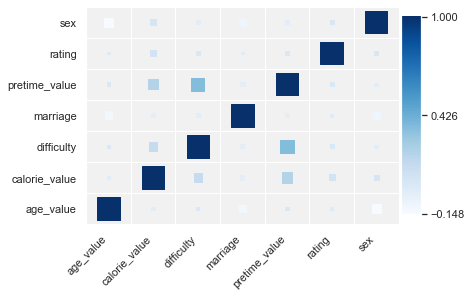

In [138]:
from heatmap import heatmap, corrplot
import copy
corr = tf.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
corr2 = copy.deepcopy(corr)
for i in range(len(corr2)):
    if corr2.iloc[i]['value'] != corr2.iloc[i]['value'] :
        corr2.at[i,'value'] = 0
    
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color = corr2['value']
)

## Boxplot between age and marriage status

- refers to https://plotly.com/python/box-plots/

In [264]:
import random
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [277]:
df_com_new = df_com_dum_calorie

In [271]:
labels = [i for i in df_com_new['marriage_status'].value_counts().index][::-1]
labels

['Geschieden', 'Verwitwet', 'Single', 'Vergeben', 'Verheiratet', 'None']

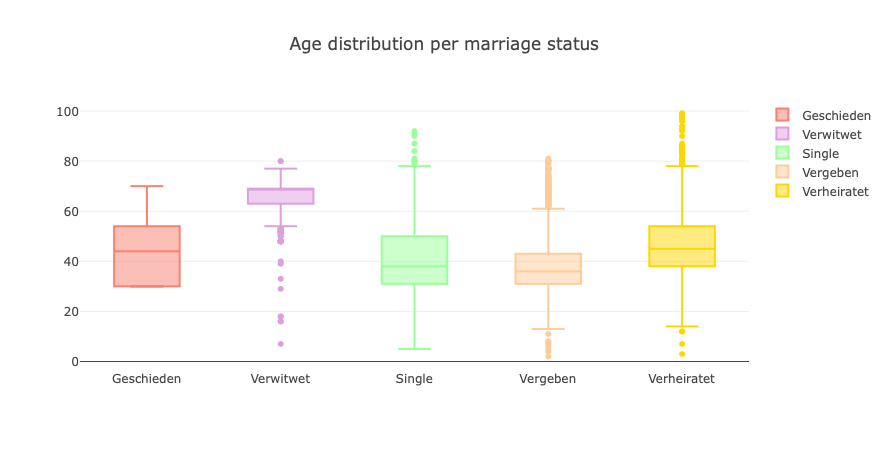

In [282]:
boxplotcolors = ['salmon','plum','#99ff99','#ffcc99',"gold","deepskyblue"]
labels = ['Geschieden', 'Verwitwet', 'Single', 'Vergeben', 'Verheiratet']
data = []
for i in range(len(labels)):
    trace = go.Box(
    y=df_com_new[df_com_new['marriage_status'] == labels[i]]['age_value'], name = labels[i],
    marker = dict(color = boxplotcolors[i]))
    data.append(trace)
layout = go.Layout(
    title = "Age distribution per marriage status "
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Box Plot Styling Outliers")

## Correlation between Calorie and Average Score

- Average score of specific recipes

In [8]:
from functions import calculate_mean
from functions import tags_preprocessing
data_tags = data_com
data_tags.reset_index(inplace = True)

In [9]:
# calculate the average score of spezialle recipes
print(calculate_mean(data_tags, 'vegan'))
print(calculate_mean(data_tags, 'diabetiker'))
print(calculate_mean(data_tags, 'dessert'))
print(calculate_mean(data_tags, 'backen'))
print(calculate_mean(data_tags, 'kartoffeln'))
print(calculate_mean(data_tags, 'vollwert'))
print(calculate_mean(data_tags, 'fettarm'))
print(calculate_mean(data_tags, 'kalorienarm'))

vegan    3.821501
dtype: float64
diabetiker    3.536159
dtype: float64
dessert    3.712578
dtype: float64
backen    3.82238
dtype: float64
kartoffeln    3.75167
dtype: float64
vollwert    3.723252
dtype: float64
fettarm    3.686425
dtype: float64
kalorienarm    3.6611
dtype: float64


In [10]:
# calculate the average score of recipes with different cooking styles
print(calculate_mean(data_tags, 'auflauf'))
print(calculate_mean(data_tags, 'blanchieren'))
print(calculate_mean(data_tags, 'braten'))
print(calculate_mean(data_tags, 'dünsten'))
print(calculate_mean(data_tags, 'flambieren'))
print(calculate_mean(data_tags, 'frittieren'))
print(calculate_mean(data_tags, 'kochen'))
print(calculate_mean(data_tags, 'marinieren'))
print(calculate_mean(data_tags, 'mikrowelle'))
print(calculate_mean(data_tags, 'römertopf'))
print(calculate_mean(data_tags, 'schmoren'))

auflauf    3.725092
dtype: float64
blanchieren    3.7
dtype: float64
braten    3.717068
dtype: float64
dünsten    3.753743
dtype: float64
flambieren    3.85125
dtype: float64
frittieren    3.75365
dtype: float64
Series([], dtype: float64)
marinieren    3.806978
dtype: float64
mikrowelle    3.625941
dtype: float64
römertopf    3.788519
dtype: float64
schmoren    3.762687
dtype: float64


In [11]:
# calculate the average score of festival recipes
print(calculate_mean(data_tags, 'halloween'))
print(calculate_mean(data_tags, 'ostern'))
print(calculate_mean(data_tags, 'silvester'))
print(calculate_mean(data_tags, 'weihnachten'))

halloween    3.712813
dtype: float64
ostern    3.772017
dtype: float64
silvester    3.783333
dtype: float64
weihnachten    3.809098
dtype: float64


In [12]:
# calculate the average score of seasonal recipes
print(calculate_mean(data_tags, 'frühling'))
print(calculate_mean(data_tags, 'sommer'))
print(calculate_mean(data_tags, 'herbst'))
print(calculate_mean(data_tags, 'winter'))

frühling    3.755745
dtype: float64
sommer    3.747945
dtype: float64
herbst    3.781872
dtype: float64
winter    3.806445
dtype: float64


- ridge-line plot of calorie distribution of specific recipes

refers to https://datavizpyr.com/ridgeline-plot-in-python-with-seaborn/

In [13]:
# choose the columns, which we need, from the original dataset
df_ridge = data_com[['recipe_name','tags','calorie_value','categorize','preparation_time']]
df_ridge["pre_time"] = df_ridge["preparation_time"].str.extract(pat, flags=0, expand=True)
df_ridge[['calorie_value']] = df_ridge[['calorie_value']].astype(int)
df_ridge[['pre_time']] = df_ridge[['pre_time']].astype(int)
df_ridge = df_ridge.drop('preparation_time',1)
df_ridge.head()

/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/sunwen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,recipe_name,tags,calorie_value,categorize,pre_time
0,"""Aufgehende Sonne""","['Asien', 'Hauptspeise', 'Nudeln', 'Beilage', ...",500,Menüart,30
1,"""Bleib gesund""-Smoothie SuperNova","['Getränk', 'Vegetarisch', 'Frühstück', 'kalor...",205,Menüart,5
2,"""Eiersalat"" vegan","['Salat', 'Vegetarisch', 'Aufstrich', 'Vegan',...",302,Menüart,10
3,"""Essbare Juwelen""","['Asien', 'Vegetarisch', 'Party', 'Vegan', 'De...",120,Menüart,15
4,"""Falsche"" Macarons","['Backen', 'Vegetarisch', 'Dessert', 'Kinder',...",2062,Menüart,30


In [14]:

# reset the index for the tags processing
df_r_1 = df_ridge
df_r_1.reset_index(inplace = True)

# add one column 'Speziell' to store the tags of 'Spezielles'
df_r_1['Spezielles']='other recipes'
for i in range(len(df_r_1)):
    tags = df_r_1.loc[i]['tags']
    tags = tags_preprocessing(tags)
    if "dessert" in tags:
        df_r_1.at[i,'Spezielles'] ='dessert'
    if "vegan" in tags:
        df_r_1.at[i,'Spezielles'] ='vegan'
    if "diabetiker" in tags:
        df_r_1.at[i,'Spezielles'] ='diabetiker'
    if "festlich" in tags:
        df_r_1.at[i,'Spezielles'] ='festlich'  
df_r_1 = df_r_1[(df_r_1["calorie_value"]>1) & (df_r_1["calorie_value"]<600)]

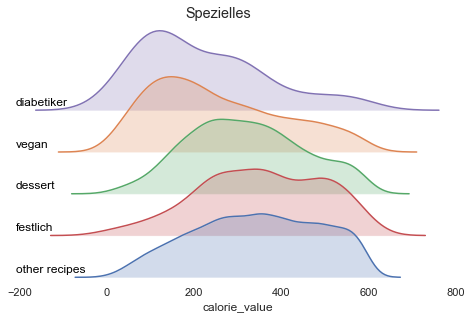

In [15]:
# plot the ridge-line of calorie distribution of spezielles recipes
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_r_1, row="Spezielles", hue="Spezielles",row_order=['diabetiker','vegan',
                                                                             'dessert','festlich','other recipes'],
                 aspect=8, height=0.9)

g.map(sns.kdeplot, "calorie_value", clip_on=False, shade=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="normal", color='black',
            ha="left", va="center",transform=ax.transAxes)
g.map(label, "calorie_value")
g.fig.subplots_adjust(hspace=-.50)
g.set_titles("")
g.set(yticks=[])
g.fig.suptitle('Spezielles')
g.despine(bottom=True, left=True)


In [16]:
df_r_2 = df_ridge
# add one column 'Speziell' to store the tags of 'cooking styles'
df_r_2['cooking_style']='other recipe'
for i in range(len(df_r_2)):
    tags = df_r_2.loc[i]['tags']
    tags = tags_preprocessing(tags)
    if "flambieren" in tags :
        df_r_2.at[i,'cooking_style'] ='flambieren'
    if "backen" in tags:
        df_r_2.at[i,'cooking_style'] ='backen'
    if "mikrowelle" in tags:
        df_r_2.at[i,'cooking_style'] ='mikrowelle'
    if "blanchieren" in tags:
        df_r_2.at[i,'cooking_style'] ='blanchieren' 
df_r_2 = df_r_2[(df_r_2["calorie_value"]>1) & (df_r_2["calorie_value"]<1200)]

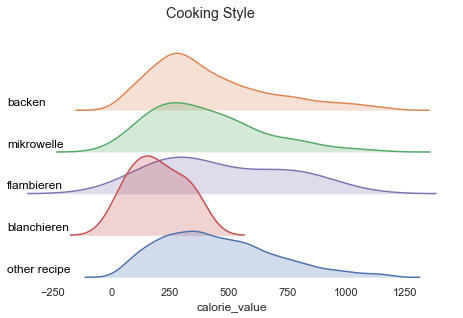

In [17]:
# plot the ridge-line of calorie distribution of different cooking styles recipes
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_r_2, row="cooking_style", hue="cooking_style",row_order=['backen','mikrowelle',
                                                                             'flambieren','blanchieren','other recipe'],
                 aspect=8, height=0.9)

g.map(sns.kdeplot, "calorie_value", clip_on=False, shade=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="normal", color='black',
            ha="left", va="center",transform=ax.transAxes)
g.map(label, "calorie_value")
g.fig.subplots_adjust(hspace=-.50)
g.set_titles("")
g.set(yticks=[])
g.fig.suptitle('Cooking Style')
g.despine(bottom=True, left=True)

In [18]:
df_r_3 = df_ridge
# add one column 'festival' to store the tags of 'festival'
df_r_3['festival']='other recipes'
for i in range(len(df_r_3)):
    tags = df_r_3.loc[i]['tags']
    tags = tags_preprocessing(tags)
    if "halloween" in tags :
        df_r_3.at[i,'festival'] ='halloween'
    if "ostern" in tags:
        df_r_3.at[i,'festival'] ='ostern'
    if "weihnachten" in tags:
        df_r_3.at[i,'festival'] ='weihnachten'
    if "silvester" in tags:
        df_r_3.at[i,'festival'] ='silvester'       

df_r_3 = df_r_3[(df_r_3["calorie_value"]>1) & (df_r_3["calorie_value"]<1200)]

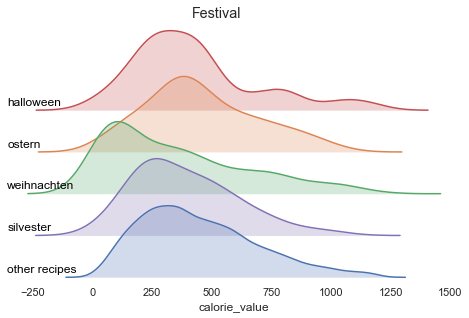

In [19]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_r_3, row="festival", hue="festival",row_order=['halloween','ostern',
                                                                             'weihnachten','silvester','other recipes'],
                 aspect=8, height=0.9)

g.map(sns.kdeplot, "calorie_value", clip_on=False, shade=True)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="normal", color='black',
            ha="left", va="center",transform=ax.transAxes)
g.map(label, "calorie_value")
g.fig.subplots_adjust(hspace=-.50)
g.set_titles("")
g.set(yticks=[])
g.fig.suptitle('Festival')
g.despine(bottom=True, left=True)


## Subgroup Discovery

In this section we will use subgroup discovery to explore the association rules between attributes

- why we choose subgroup discovery?

because we find out that subgroup discovery is quite powerful compared to other data mining techniques. As long as we set differnt target with different search space, we can use use subgroup discovery technique to dig many interesting patterns that we want to explore from the dataset. 


#### Prepare data, remove none

In [18]:
# remove none value in the whole data set 
df_com_no_none = df_com_new.mask(df_com_new.astype(object).eq('None')).dropna()
df_com_no_none = df_com_no_none.reset_index()

# calculate and add calorie level , preparation time and age group columns in the comment user information
df_com_no_none["pretime_value"] = df_com_no_none["preparation_time"].str.extract(pat, flags=0, expand=True)
df_com_no_none['pre_time_group'] = df_com_no_none['pretime_value'].apply(pre_time_group)

df_com_no_none['calorie_level'] = df_com_no_none['calorie_value'].apply(calorie_level)
df_dum_calorie = pd.get_dummies(df_com_no_none['calorie_level'])

df_com_no_none["age_value"] = df_com_no_none["age"].str.extract(pat, flags=0, expand=True)
df_com_no_none['age_group'] = df_com_no_none['age_value'].apply(age_group)

df_com_dum_calorie = df_com_no_none.join(df_dum_calorie, how='left')

In [19]:
df_com_dum_calorie['age_group'].value_counts()

30-45 Jahre    44129
45-60 Jahre    27268
60+ Jahre       7598
<30 Jahre       7583
Name: age_group, dtype: int64

In [20]:
df_com_dum_calorie['sex'].value_counts()

weiblich    73967
männlich    12611
Name: sex, dtype: int64

In [21]:
df_com_dum_calorie['calorie_level'].value_counts()

high_calorie      47498
medium_calorie    19607
low_calorie       19473
Name: calorie_level, dtype: int64

In [22]:
df_com_dum_calorie['marriage_status'].value_counts()

Verheiratet    46903
Vergeben       28891
Single          8863
Verwitwet       1483
Geschieden       438
Name: marriage_status, dtype: int64

#### Subgroup discovery 

In [124]:
data = df_com_dum_calorie[['sex', 'age_group', 'high_calorie', 'low_calorie', 'medium_calorie','marriage_status']]
print("the length of dataset:", len(data))
target = ps.BinaryTarget('low_calorie', True)
searchspace = ps.create_selectors(data, ignore=['high_calorie', 'low_calorie', 'medium_calorie'])
task = ps.SubgroupDiscoveryTask (
    data, 
    target, 
    searchspace, 
    result_set_size=5, 
    depth=2, 
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)
pd.set_option('max_colwidth',100)
print(result.to_dataframe())

the length of dataset: 86578
    quality                                       description
0  0.002293        age_group=='60+ Jahre' AND sex=='weiblich'
1  0.002045                            age_group=='60+ Jahre'
2  0.002012      age_group=='45-60 Jahre' AND sex=='weiblich'
3  0.001980                                   sex=='weiblich'
4  0.001774  marriage_status=='Verwitwet' AND sex=='weiblich'


## Discover why differnt calorie-level is preferred by these particular groups

In [125]:
def get_distinct_tag(df):
    distinct_tags = []
    for i in range(len(df)):
        distinct_tags += df.iloc[i]['tags']
    return list(set(distinct_tags))

In [126]:
downsampled_new = df_com_dum_calorie
downsampled_new = downsampled_new.reset_index()
downsampled_new['tags'] = downsampled_new['tags'].astype(object)
for i in range(len(downsampled_new)):
    tags = downsampled_new.iloc[i]['tags']
    tags = tags_preprocess(tags)
    downsampled_new.at[i, 'tags'] = tags

In [127]:
# prepare the data for multiclass classifier
df = downsampled_new[['tags', 'sex', 'age_group', 'marriage_status', 'calorie_level']]
distinct_tags = get_distinct_tag(df)

# One hot encoding of the ingredients
df['tags'] = df.tags.apply(convert_to_dict)
vectorizer = DictVectorizer(sparse=False)
new_df = pd.DataFrame(data = vectorizer.fit_transform(df.tags.tolist()), columns = distinct_tags)
new_df[['sex', 'age_group', 'marriage_status', 'calorie_level']] = df[['sex', 'age_group', 'marriage_status', 'calorie_level']]

# set the target value by combining 'sex', 'age_group', 'marriage_status'
new_df['combine'] = new_df[['sex', 'age_group', 'marriage_status']].values.tolist()
new_df['combine'] = new_df['combine'].astype(str)

/Users/xujingjing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [133]:
# multiclass classifer
clf_X = new_df.iloc[:, :-5]
y = new_df.iloc[:, -1]

def computeIDF(clf_X):
    num_document = len(clf_X)
    idf_row = clf_X.sum(axis = 0, skipna = True) 
    idf_row = len(clf_X)/idf_row
    return idf_row

def computeTF(clf_X):
    clf_X['sum'] = clf_X.sum(axis = 1, skipna = True)
    clf_X = clf_X.div(clf_X['sum'], axis=0)
    clf_X = clf_X.drop(['sum'],axis = 1)
    return clf_X

idf_row = computeIDF(clf_X)
clf_X = computeTF(clf_X)
#clf_X = clf_X*idf_row
clf_X = clf_X.fillna(0)

In [134]:
from sklearn import svm
#clf = svm.LinearSVC()
clf = LogisticRegression(max_iter=1500)
#clf = RidgeClassifier()
clf.fit(clf_X, y)
y_pred = clf.predict(clf_X)

# accuracy 
print("Accuracy:",clf.score(clf_X, y))

Accuracy: 0.2431218092356026


In [130]:
df = pd.DataFrame()
for i in range(len(clf.classes_)):
    if clf.classes_[i] != 'overlap':
        df[clf.classes_[i]] = [vectorizer.feature_names_[ing_id] for ing_id in np.argsort(-clf.coef_[i])[:10]]
df

,"['männlich', '30-45 Jahre', 'Geschieden']","['männlich', '30-45 Jahre', 'Single']","['männlich', '30-45 Jahre', 'Vergeben']","['männlich', '30-45 Jahre', 'Verheiratet']","['männlich', '30-45 Jahre', 'Verwitwet']","['männlich', '45-60 Jahre', 'Geschieden']","['männlich', '45-60 Jahre', 'Single']","['männlich', '45-60 Jahre', 'Vergeben']","['männlich', '45-60 Jahre', 'Verheiratet']","['männlich', '45-60 Jahre', 'Verwitwet']",...,"['weiblich', '45-60 Jahre', 'Verwitwet']","['weiblich', '60+ Jahre', 'Geschieden']","['weiblich', '60+ Jahre', 'Single']","['weiblich', '60+ Jahre', 'Vergeben']","['weiblich', '60+ Jahre', 'Verheiratet']","['weiblich', '60+ Jahre', 'Verwitwet']","['weiblich', '<30 Jahre', 'Single']","['weiblich', '<30 Jahre', 'Vergeben']","['weiblich', '<30 Jahre', 'Verheiratet']","['weiblich', '<30 Jahre', 'Verwitwet']"
0,spezial,usaoderkanada,hülsenfrüchte,grillen,wok,fleisch,hauptspeise,klar,china,hauptspeise,...,vegetarisch,gluten,kuchen,salat,haltbarmachen,beilage,fettarm,nudeln,backen,gluten
1,suppe,pasta,eintopf,longdrink,studentenküche,gekocht,grillen,hauptspeise,europa,pilze,...,kuchen,backen,raffiniertoderpreiswert,deutschland,frühling,salatdressing,kalorienarm,backen,gemüse,backen
2,kartoffeln,braten,usaoderkanada,alkoholfrei,pasta,lactose,paleo,eier,grillen,lowcarb,...,vegan,schnell,brotoderbrötchen,kinder,brotoderbrötchen,frühling,nudeln,trennkost,shake,vegan
3,einfach,mehlspeisen,fingerfood,getränk,nudeln,kuchen,wok,beilage,beilage,ketogen,...,schnell,einfach,backen,ketogen,vegetarisch,kartoffel,shake,reisodernudelsalat,sommer,vegetarisch
4,europa,studentenküche,pasta,pasta,raffiniertoderpreiswert,warm,herbst,lowcarb,basisrezepte,braten,...,beilage,kuchen,snack,paleo,vegan,fisch,usaoderkanada,mehlspeisen,kuchen,beilage
5,schmoren,gekocht,asien,cocktail,schnell,eintopf,dünsten,grillen,fleisch,fingerfood,...,einfach,sommer,frühstück,fisch,fisch,vegetarisch,kinder,gebunden,torte,brotoderbrötchen
6,schnell,hauptspeise,italien,fingerfood,einfach,gluten,geheimrezept,camping,brotoderbrötchen,frittieren,...,resteverwertung,kalorienarm,lactose,süßspeise,salat,brotoderbrötchen,backen,usaoderkanada,informempfehlung,frühstück
7,brotoderbrötchen,eier,rind,reisodernudelsalat,gemüse,dessert,gekocht,wok,saucen,klar,...,sommer,kekse,warm,resteverwertung,sommer,frucht,snack,shake,mehlspeisen,kalorienarm
8,raffiniertoderpreiswert,reisgetreide,mexiko,frittieren,hauptspeise,salatdressing,asien,ketogen,portugal,party,...,backen,weihnachten,festlich,party,frühstück,braten,mehlspeisen,mexiko,tarte,fettarm
9,party,saucen,fleisch,asien,gluten,backen,beilage,früchte,hülsenfrüchte,schwein,...,dessert,usaoderkanada,europa,basisrezepte,fleisch,salat,kekse,studentenküche,lactose,kekse


In [103]:
df.iloc[:,:20]

,"['männlich', '30-45 Jahre', 'Geschieden']","['männlich', '30-45 Jahre', 'Single']","['männlich', '30-45 Jahre', 'Vergeben']","['männlich', '30-45 Jahre', 'Verheiratet']","['männlich', '30-45 Jahre', 'Verwitwet']","['männlich', '45-60 Jahre', 'Geschieden']","['männlich', '45-60 Jahre', 'Single']","['männlich', '45-60 Jahre', 'Vergeben']","['männlich', '45-60 Jahre', 'Verheiratet']","['männlich', '45-60 Jahre', 'Verwitwet']","['männlich', '60+ Jahre', 'Geschieden']","['männlich', '60+ Jahre', 'Single']","['männlich', '60+ Jahre', 'Vergeben']","['männlich', '60+ Jahre', 'Verheiratet']","['männlich', '60+ Jahre', 'Verwitwet']","['männlich', '<30 Jahre', 'Single']","['männlich', '<30 Jahre', 'Vergeben']","['männlich', '<30 Jahre', 'Verheiratet']","['weiblich', '30-45 Jahre', 'Geschieden']","['weiblich', '30-45 Jahre', 'Single']"
0,spezial,pasta,gluten,pasta,wok,eintopf,gekocht,lowcarb,fleisch,pilze,fisch,herbst,beilage,fleisch,herbst,studentenküche,nudeln,frucht,auflauf,backen
1,tarte,braten,pasta,gemüse,ägypten,warm,auflauf,schwein,lowcarb,fingerfood,raffiniertoderpreiswert,braten,herbst,hauptspeise,schmoren,sommer,fingerfood,käse,raffiniertoderpreiswert,lactose
2,dips,usaoderkanada,gewürzeölessigpasten,suppe,essig,asien,braten,beilage,beilage,ei,gebunden,salat,braten,beilage,süßspeise,nudeln,pasta,griechenland,eintopf,gluten
3,frankreich,rind,fleisch,dessert,öl,geheimrezept,saucen,hauptspeise,hauptspeise,marinieren,griechenland,schwein,fisch,raffiniertoderpreiswert,frühling,rind,geflügel,fingerfood,getränk,einfach
4,geheimrezept,gekocht,rind,rind,gewürze,früchte,herbst,gekocht,deutschland,frittieren,aufstrich,gekocht,frühling,deutschland,resteverwertung,frühstück,rind,italien,fettarm,auflauf
5,schweiz,hauptspeise,gemüse,gluten,pasten,einlagen,beilage,fleisch,dessert,klar,schmoren,nudeln,schmoren,pasta,camping,braten,italien,basisrezepte,camping,kuchen
6,mexiko,herbst,schnell,schwein,grundrezepte,marokko,hauptspeise,rind,braten,china,ei,italien,kekse,herbst,tarte,auflauf,dessert,kalt,schwein,fettarm
7,überbacken,studentenküche,suppe,lowcarb,belgien,gekocht,suppe,schweden,schwein,mexiko,frankreich,weihnachten,einfach,braten,pilze,kuchen,mehlspeisen,süßspeise,salat,kalt
8,schmoren,suppe,sommer,backen,korea,eier,paleo,usaoderkanada,winter,karibikundexotik,eieroderkäse,frühling,schnell,auflauf,gebunden,kinder,gemüse,meeresfrüchte,haltbarmachen,raffiniertoderpreiswert
9,hülsenfrüchte,dessert,ketogen,auflauf,flambieren,fleisch,dünsten,herbst,pasta,lateinamerika,vollwert,deutschland,eintopf,fisch,kartoffel,vegan,lowcarb,haltbarmachen,kekse,rind


In [131]:
# high-calorie
a_1 =['weiblich', '30-45 Jahre', 'Verheiratet']
a_1 = str(a_1)
a_2 = ['weiblich', '30-45 Jahre', 'Vergeben']
a_2 = str(a_2)
df[[a_1,a_2]]

,"['weiblich', '30-45 Jahre', 'Verheiratet']","['weiblich', '30-45 Jahre', 'Vergeben']"
0,russland,mexiko
1,auflauf,auflauf
2,babynahrung,usaoderkanada
3,backen,fettarm
4,kinder,trennkost
5,halloween,geflügel
6,mexiko,reisodernudelsalat
7,türkei,reisgetreide
8,reisodernudelsalat,backen
9,aufstrich,kekse


In [132]:
# medium-calorie
b_1 = ['weiblich', '45-60 Jahre', 'Verheiratet']
b_1 = str(b_1)
columns = list(df.columns)
cols_b = [l for l in columns if "Verheiratet" in l and "60+ Jahre" in l]
cols_b.append(b_1)
df[cols_b]

,"['männlich', '60+ Jahre', 'Verheiratet']","['weiblich', '60+ Jahre', 'Verheiratet']","['weiblich', '45-60 Jahre', 'Verheiratet']"
0,fisch,haltbarmachen,brotoderbrötchen
1,hauptspeise,frühling,salat
2,herbst,brotoderbrötchen,haltbarmachen
3,raffiniertoderpreiswert,vegetarisch,ostern
4,winter,vegan,auflauf
5,deutschland,fisch,österreich
6,festlich,salat,früchte
7,europa,sommer,kalt
8,beilage,frühstück,einlagen
9,schmoren,fleisch,aufstrich


In [97]:
cols_c = [l for l in columns if "weiblich" in l and "60+ Jahre" in l]
cols_c += [l for l in columns if "weiblich" in l and "Verwitwet" in l]
df[cols_c]

,"['weiblich', '60+ Jahre', 'Geschieden']","['weiblich', '60+ Jahre', 'Single']","['weiblich', '60+ Jahre', 'Vergeben']","['weiblich', '60+ Jahre', 'Verheiratet']","['weiblich', '60+ Jahre', 'Verwitwet']","['weiblich', '30-45 Jahre', 'Verwitwet']","['weiblich', '45-60 Jahre', 'Verwitwet']","['weiblich', '60+ Jahre', 'Verwitwet']","['weiblich', '<30 Jahre', 'Verwitwet']"
0,dips,kuchen,ketogen,vegetarisch,vegetarisch,ei,vegan,vegetarisch,frankreich
1,usaoderkanada,snack,party,lactose,beilage,camping,resteverwertung,beilage,vollwert
2,wok,raffiniertoderpreiswert,salat,fleisch,lowcarb,ägypten,kuchen,lowcarb,tarte
3,grillen,camping,kinder,kuchen,vorspeise,gewürze,fingerfood,vorspeise,brotoderbrötchen
4,türkei,weihnachten,weihnachten,gewürzeölessigpasten,dessert,öl,saucen,dessert,kekse
5,osteuropa,warm,deutschland,skandinavien,gewürzeölessigpasten,essig,überbacken,gewürzeölessigpasten,kalorienarm
6,marokko,italien,fingerfood,vorspeise,gekocht,pasten,schmoren,gekocht,vegan
7,ostern,pilze,studentenküche,hauptspeise,winter,grundrezepte,indien,winter,ägypten
8,spezial,brotoderbrötchen,basisrezepte,brotoderbrötchen,brotoderbrötchen,belgien,reisgetreide,brotoderbrötchen,öl
9,reisodernudelsalat,eieroderkäse,raffiniertoderpreiswert,salat,kartoffeln,korea,beilage,kartoffeln,essig


- kdeplot of backen recipes and backen&gluten&lactose recipes

In [33]:
df_backen = df_ridge
# Filter out the recipes with 'lactose','backen' and 'gluten' tags
df_backen['material']=None
for i in range(len(df_backen)):
    tags = df_backen.loc[i]['tags']
    tags = tags_preprocessing(tags)
    if "backen" in tags and 'lactose' in tags and 'gluten' in tags:
        df_backen.at[i,'material'] ='lactose&gluten&backen'
df_backen = df_backen[(df_backen["calorie_value"]>1) & (df_backen["calorie_value"]<5000) ]

In [34]:
# divided all the recipes into all different cooking methods
from functions import get_cooking_method
cook_method = ['auflauf','gekocht','backen','blanchieren',
               'braten','römertopf','mikrowelle']
df_cook_new = get_cooking_method(cook_method, df_ridge)

# drop the recipes with with 'lactose','backen' and 'gluten' tags
y = df_cook_new[df_cook_new['material'] == 'lactose&gluten&backen']
index_n = y.index.tolist()
df_cook_2 = df_cook_new.drop(index = index_n)
df_cook_2 = df_cook_2[(df_cook_2["calorie_value"]>1) & (df_cook_2["calorie_value"]<4000)]

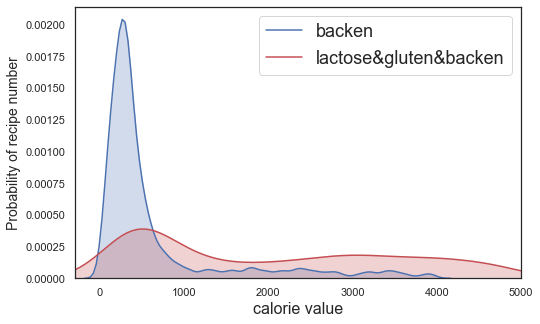

In [35]:
df_cook_2 = df_cook_2.rename(columns={'calorie_value':'backen'})
df_backen = df_backen.rename(columns={'calorie_value':'lactose&gluten&backen'})

plt.figure(figsize=(8, 5))
sns.set(style="white")

sns.kdeplot(df_cook_2.loc[(df_cook_2['cooking method']=='backen'),  
            'backen'], shade=True, color="b")
sns.kdeplot(df_backen.loc[(df_backen['material']=='lactose&gluten&backen'),  
            'lactose&gluten&backen'], shade=True, color="r")
plt.xlim(-300,5000)
plt.ylabel('Probability of recipe number',fontsize=14)
plt.xlabel('calorie value',fontsize=16)
# plt.title('specific calorie distribution',fontsize=18)
plt.legend(fontsize=18)
plt.show()